In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [3]:
# Ignore warnings
import warnings 
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
# data visualization 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [4]:
%matplotlib inline

In [5]:
# model selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score

# preprocessing
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
# tf libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D, Dropout, LeakyReLU,GlobalMaxPooling2D
from tensorflow.keras.metrics import top_k_categorical_accuracy,categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical


import keras
import tensorflow as tf
import random as rn

In [6]:
import cv2 
import os
import glob
from random import shuffle
from zipfile import ZipFile
from PIL import Image
from tqdm import tqdm



In [7]:
from keras.applications.vgg16 import VGG16

In [8]:
print(os.listdir('../input/dogs-vs-cats-redux-kernels-edition'))

['sample_submission.csv', 'train.zip', 'test.zip']


In [9]:
zip_file = glob.glob('../input/dogs-vs-cats-redux-kernels-edition/*.zip')


In [10]:
print(zip_file)

['../input/dogs-vs-cats-redux-kernels-edition/train.zip', '../input/dogs-vs-cats-redux-kernels-edition/test.zip']


In [11]:
import zipfile
def extract_zip(file):
    with zipfile.ZipFile(file,"r") as zip_ref:
        zip_ref.extractall("temp")
        

for files in zip_file:
    extract_zip(files)

In [12]:
print(len(os.listdir('/kaggle/working/temp/train')), "training data")
print(len(os.listdir('/kaggle/working/temp/test')), "test data")
os.listdir("temp")

25000 training data
12500 test data


['test', 'train']

In [13]:
# Generate labels and path for train and test data
def get_label(directory):
    label = []
    for file in os.listdir(directory):
        if (file.split(".")[0] == "dog"):
            label.append(str(0))
        if (file.split(".")[0] == "cat"):
            label.append(str(1))
    return label

def get_path(directory):
    path = []
    for file in os.listdir(directory):
            path.append(file)
    return path

train_x = get_path('temp/train')
train_y = get_label('temp/train')
test_x = get_path('temp/test')

In [14]:
df = pd.DataFrame ({ "filename" : train_x,
                    "label": train_y})
df.head()

,filename,label
0,cat.1177.jpg,1
1,cat.7479.jpg,1
2,dog.9221.jpg,0
3,cat.6371.jpg,1
4,cat.11490.jpg,1


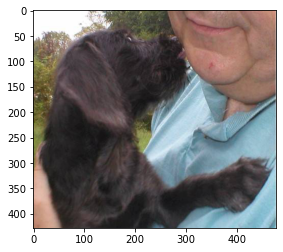

In [15]:
# Visualize training image
os.chdir("temp/train")
img = load_img(df["filename"].iloc[2])
plt.imshow(img)

In [16]:
# Split training data into train set and validation set
train_df , val_df = train_test_split(df, test_size = 0.25, random_state = 42)
train_df

,filename,label
6920,dog.12137.jpg,0
17926,cat.11861.jpg,1
1123,dog.6274.jpg,0
4518,dog.1292.jpg,0
5576,dog.2844.jpg,0
...,...,...
21575,cat.11572.jpg,1
5390,dog.2285.jpg,0
860,cat.11057.jpg,1
15795,dog.13.jpg,0


In [17]:

# data augmentation steps
train_datagen = ImageDataGenerator(    
                    rotation_range=10,
                    rescale=1./255,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    width_shift_range=0.1,
                    height_shift_range=0.1)

train_gen = train_datagen.flow_from_dataframe(
            train_df,
            x_col='filename',
            y_col= 'label',
            target_size=(224, 224),
            batch_size = 256,
            class_mode='binary',
            shuffle=False)

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_gen = valid_datagen.flow_from_dataframe(
            val_df,
            x_col='filename',
            y_col='label',
            target_size=(224, 224),
            batch_size = 256,
            class_mode='binary')


Found 18750 validated image filenames belonging to 2 classes.
Found 6250 validated image filenames belonging to 2 classes.


In [18]:
base_model = VGG16(include_top=False, weights= "imagenet" ,input_shape=(224,224,3), pooling='avg')


In [19]:
for layers in base_model.layers:
    layers.trainable=False
print(base_model.output)

Tensor("global_average_pooling2d/Identity:0", shape=(None, 512), dtype=float32)


In [20]:
epochs=5
batch_size=256


In [21]:
model = Sequential()
model.add(base_model)
model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))



In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 14,846,273
Trainable params: 131,585
Non-trainable params: 14,714,688
_________________________________________________________________


In [23]:
model.compile(optimizer=Adam(lr=1e-2),loss='binary_crossentropy',metrics=['accuracy'])

In [24]:
callback=[keras.callbacks.EarlyStopping(monitor='val_acc', patience=20, verbose=1, mode='auto', restore_best_weights=True),
         keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto')]
History = model.fit_generator(train_gen,
                              epochs = epochs, validation_data = valid_gen,
                              verbose = 1,validation_steps= valid_gen.samples // batch_size, steps_per_epoch=train_gen.samples // batch_size, callbacks = callback)

Epoch 1/5
 2/73 [..............................] - ETA: 42:42 - loss: 2.1861 - accuracy: 0.4980

KeyboardInterrupt: 

In [ ]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()